In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2025-11-21 09:36:00.811362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763714160.941171    9896 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763714160.976620    9896 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763714161.341146    9896 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763714161.341167    9896 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763714161.341169    9896 computation_placer.cc:177] computation placer alr

In [2]:
print(tf.__version__)

2.19.1


In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


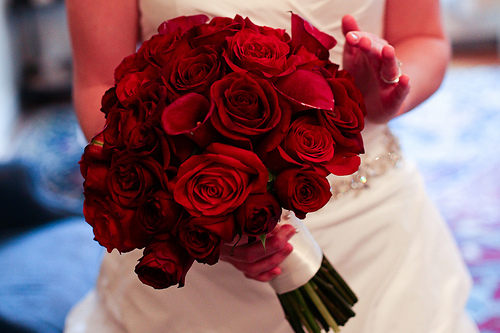

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

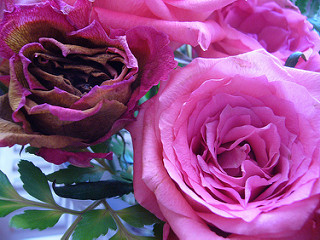

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


I0000 00:00:1763714243.206851    9896 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9040 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2025-11-21 09:38:07.079085: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


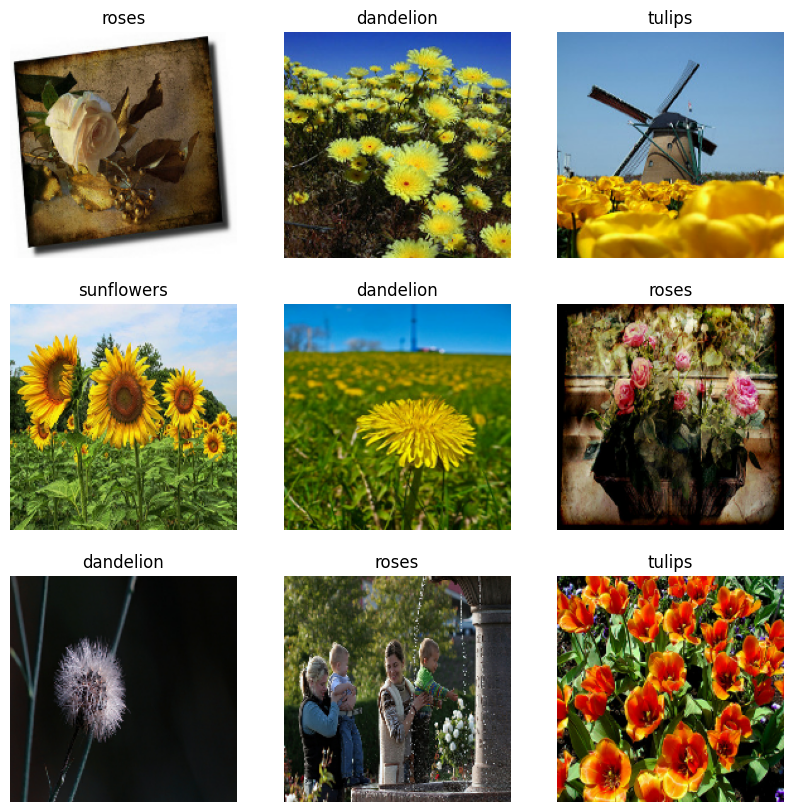

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [17]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [18]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


I0000 00:00:1763714350.780966   11328 service.cc:152] XLA service 0x7ce0900063f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763714350.780984   11328 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-21 09:39:10.840792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763714350.993517   11328 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-21 09:39:11.398614: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,178,178]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,180,180]{3,2,1,0} %bitcast.2547, f32[32,3,3,3]{3,2,1,0} %bitcast.2341, f32[32]{0} %bitcast.2878), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$

 7/92 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2000 - loss: 1.7187

I0000 00:00:1763714354.403139   11328 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3774 - loss: 1.4211

2025-11-21 09:39:16.621771: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.11 = (f32[24,32,41,41]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,32,43,43]{3,2,1,0} %bitcast.3068, f32[32,32,3,3]{3,2,1,0} %bitcast.2380, f32[32]{0} %bitcast.3128), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_2_1/convolution" source_file="/home/xy/Desktop/ml/TF/tf_2.19.1/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-11-21 09:39:16.977264: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: m

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3782 - loss: 1.4196

2025-11-21 09:39:18.135792: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,178,178]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,180,180]{3,2,1,0} %bitcast.521, f32[32,3,3,3]{3,2,1,0} %bitcast.528, f32[32]{0} %bitcast.530), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/xy/Desktop/ml/TF/tf_2.19.1/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-11-21 09:39:18.466492: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measu

92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4530 - loss: 1.2833 - val_accuracy: 0.5708 - val_loss: 1.0911
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6012 - loss: 1.0019 - val_accuracy: 0.5777 - val_loss: 1.0433
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6686 - loss: 0.8501 - val_accuracy: 0.6131 - val_loss: 0.9929


In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [20]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/xy/.keras/datasets/flower_photos/sunflowers/5979111025_3bcae48ae6_n.jpg'
b'/home/xy/.keras/datasets/flower_photos/roses/2535466393_6556afeb2f_m.jpg'
b'/home/xy/.keras/datasets/flower_photos/dandelion/148698493_5710e5f472.jpg'
b'/home/xy/.keras/datasets/flower_photos/dandelion/2503034372_db7867de51_m.jpg'
b'/home/xy/.keras/datasets/flower_photos/daisy/3639009391_0f910681b7.jpg'


2025-11-21 09:39:35.435229: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [22]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [24]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [25]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [26]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [27]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


In [29]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

2025-11-21 09:41:24.009172: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


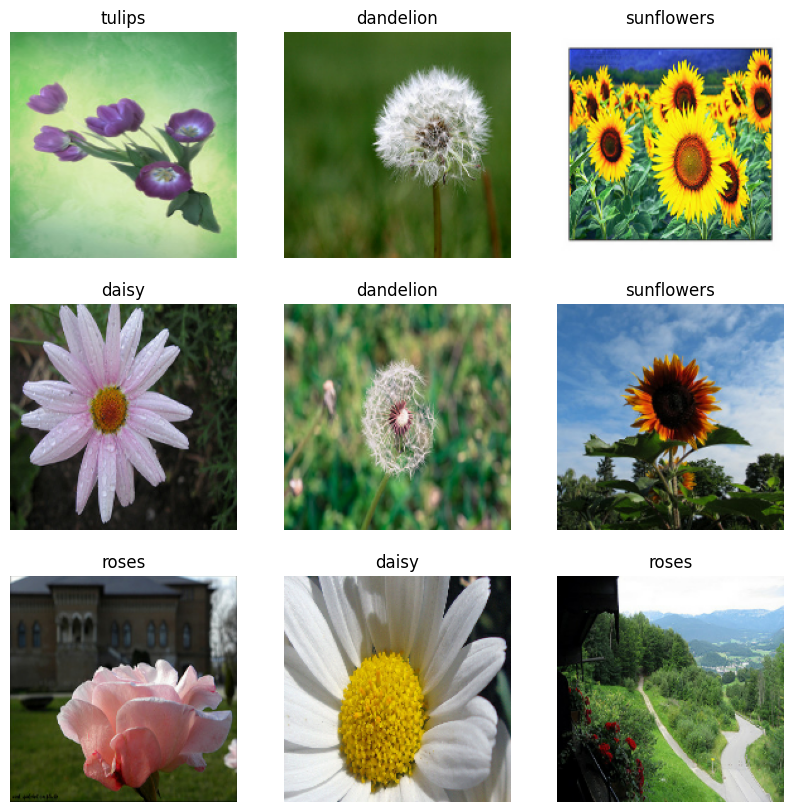

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [31]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7187 - loss: 0.7557 - val_accuracy: 0.7439 - val_loss: 0.6494
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7973 - loss: 0.5416 - val_accuracy: 0.7589 - val_loss: 0.6808
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8777 - loss: 0.3573 - val_accuracy: 0.7384 - val_loss: 0.7009


In [32]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

/home/xy/Desktop/ml/TF/tf_2.19.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Generating splits...:   0%|                          | 0/1 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 3187 examples [00:01, 3185.95 examples/s]
                                                                       
Shuffling /home/xy/tensorflow_datasets/tf_flowers/incomplete.CBANJA_3.0.1/tf_flo
                                                                                

Dataset tf_flowers downloaded and prepared to /home/xy/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [33]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2025-11-21 09:42:12.345359: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-21 09:42:12.351337: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


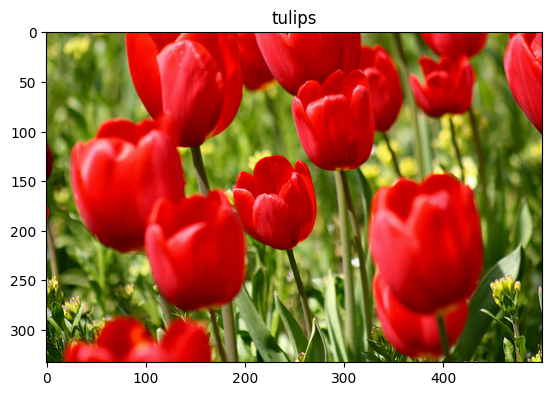

In [34]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [35]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)